In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import matplotlib.cm as cm

#set stepsize patterns
H_GRDESC = [1]
H_2 = [2.9, 1.5] # taking nu = 0.1
H_3 = [1.5, 4.9, 1.5]
H_7 = [1.5, 2.2, 1.5, 12.0, 1.5, 2.2, 1.5]
H_15 = [1.4, 2.0, 1.4, 4.5, 1.4, 2.0, 1.4, 29.7, 1.4, 2.0, 1.4, 4.5, 1.4, 2.0, 1.4]
H_31 = [1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 8.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 72.3, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 8.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4]
H_63 = [1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 14.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 164.0, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 14.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4]
H_127 = [1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 12.6, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 23.5, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 12.6, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 370.0, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 12.6, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 23.5, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.5, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 12.6, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4]

H = [H_GRDESC,H_2,H_3,H_7,H_15,H_31,H_63,H_127]
# H = [H_GRDESC,H_2]

# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#evaluate objective function without regularizer
def objective1(outputs, labels, model = None):
    # Convert labels to one-hot encoding
    labels_onehot = torch.zeros_like(outputs)
    for i, label in enumerate(labels):
        labels_onehot[i][label] = 1
    
    return nn.MSELoss()(outputs, labels_onehot)
# torch.norm(outputs - labels_onehot, p=2, dim=1).pow(2).mean()

#...with regularizer
def objective2(outputs, labels, model):
    return objective1(outputs, labels, model) + torch.norm(model.linear.weight, p=2 , dim=1).pow(2).mean()


# Define the linear model
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(784, 10, bias=False)  # 28x28 = 784 input features, 10 output classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        return self.linear(x)

    # Define the custom non-constant step sizes
    def step_size_schedule(self, epoch, H, image = None):
        h = H[(epoch-1) % len(H)]
        # L = 2 * torch.norm(image.view(image.size(0), -1), p=2)**2
        return h / 4783.4

   
   # Define the data transforms including normalization
transform = transforms.Compose([
    ToTensor(), # automatically scales the images to [0,1] range
    Normalize((0.1307,), (0.3081,)) # calulated from the training dataset
])


# Load the MNIST dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True) # Batch size of 1
print(f"Number of training examples: {len(train_dataset)}")


# Load MNIST test data
test_dataset = MNIST(root='./data', train=False, download=True)
# The transform is applied only when accessing the data via for ... in ... loop 

# Extract images (X_test) and labels (y_test) from the test dataset
X_test = test_dataset.data[:1000].unsqueeze(1).float()#.to(device)  # Add a channel dimension and convert to float
y_test = test_dataset.targets[:1000]#.to(device)
print(f"Number of test examples: {len(X_test)}")

# # Calculate the mean and standard deviation
X_test = X_test.float() /255.0
mean = X_test.mean()
std = X_test.std()

X_test = (X_test - mean) / std  # Normalize the test data

# print('Mean:', mean)
# print('Std:', std)
# print(X_test[0][0][21])
# print(y_test[0])

Number of training examples: 60000
Number of test examples: 1000


In [54]:
L = 0
for images, _ in train_loader:
    norm = torch.norm(images.view(images.size(0), -1), p=2, dim=1).pow(2)
    L = max(L, 2* norm.max())

print(f"Estimated L: {L}")

Estimated L: 4783.421875


In [55]:
losses_H = []
test_error_rates_H = []
for H_i in H:
    criterion = objective1 
    # Create the linear model
    model = LinearModel()#.to(device)
    # nn.init.xavier_uniform_(model.linear.weight) # Initialize the weights using Xavier initialization
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    # Lists to store the loss values and test errors
    losses = []
    test_error_rates = []

    # Train the model
    for epoch in tqdm(range(30)):
        for images, labels in train_loader:
            # images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            # Update the learning rate for every batch
            optimizer.param_groups[0]['lr'] = model.step_size_schedule(epoch, H_i, images)

            output = model(images)
            loss = criterion(output, labels, model) # x is weight, A is image data, b is label data, Ax=b
            loss.backward()
            # Add gradient clipping
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Record the loss
            losses.append(loss.item())

            # Test the model
            # Calculate test error using test data
            with torch.no_grad():
                outputs = model(X_test)
                predicted_labels = torch.argmax(outputs, dim=1)
                # test_error_rate = criterion(outputs, y_test, model)

                # Calculate the error rate
                test_error_rate = 1.0 - torch.sum(predicted_labels == y_test).item() / len(y_test)
            
            test_error_rates.append(test_error_rate)

        print(f"Epoch {epoch+1}: Training Loss = {loss.item()}")
        
    losses_H.append(losses)
    test_error_rates_H.append(test_error_rates)

# Save the loss and test error data
np.save('losses_H.npy', losses_H)
np.save('test_error_rates_H.npy', test_error_rates_H)


  3%|▎         | 1/30 [00:06<03:09,  6.52s/it]

Epoch 1: Training Loss = 0.24674977362155914


  7%|▋         | 2/30 [00:12<02:55,  6.28s/it]

Epoch 2: Training Loss = 0.2171003222465515


 10%|█         | 3/30 [00:18<02:47,  6.21s/it]

Epoch 3: Training Loss = 0.19456908106803894


 13%|█▎        | 4/30 [00:24<02:40,  6.17s/it]

Epoch 4: Training Loss = 0.19030745327472687


 17%|█▋        | 5/30 [00:30<02:33,  6.13s/it]

Epoch 5: Training Loss = 0.19427332282066345


 20%|██        | 6/30 [00:37<02:26,  6.12s/it]

Epoch 6: Training Loss = 0.1871400773525238


 23%|██▎       | 7/30 [00:43<02:22,  6.18s/it]

Epoch 7: Training Loss = 0.14960774779319763


 27%|██▋       | 8/30 [00:49<02:15,  6.16s/it]

Epoch 8: Training Loss = 0.14599426090717316


 30%|███       | 9/30 [00:55<02:08,  6.13s/it]

Epoch 9: Training Loss = 0.15780411660671234


 33%|███▎      | 10/30 [01:01<02:03,  6.17s/it]

Epoch 10: Training Loss = 0.1379709392786026


 37%|███▋      | 11/30 [01:07<01:56,  6.12s/it]

Epoch 11: Training Loss = 0.14505167305469513


 40%|████      | 12/30 [01:13<01:49,  6.11s/it]

Epoch 12: Training Loss = 0.13786998391151428


 43%|████▎     | 13/30 [01:19<01:43,  6.09s/it]

Epoch 13: Training Loss = 0.13641086220741272


 47%|████▋     | 14/30 [01:25<01:37,  6.09s/it]

Epoch 14: Training Loss = 0.13189472258090973


 50%|█████     | 15/30 [01:32<01:31,  6.09s/it]

Epoch 15: Training Loss = 0.12928065657615662


 53%|█████▎    | 16/30 [01:38<01:25,  6.08s/it]

Epoch 16: Training Loss = 0.12418340891599655


 57%|█████▋    | 17/30 [01:44<01:18,  6.05s/it]

Epoch 17: Training Loss = 0.11444123834371567


 60%|██████    | 18/30 [01:50<01:12,  6.04s/it]

Epoch 18: Training Loss = 0.1163799837231636


 63%|██████▎   | 19/30 [01:56<01:06,  6.05s/it]

Epoch 19: Training Loss = 0.1204586923122406


 67%|██████▋   | 20/30 [02:02<01:00,  6.07s/it]

Epoch 20: Training Loss = 0.11408409476280212


 70%|███████   | 21/30 [02:08<00:54,  6.05s/it]

Epoch 21: Training Loss = 0.11178820580244064


 73%|███████▎  | 22/30 [02:14<00:48,  6.04s/it]

Epoch 22: Training Loss = 0.10803767293691635


 77%|███████▋  | 23/30 [02:20<00:42,  6.03s/it]

Epoch 23: Training Loss = 0.09898659586906433


 80%|████████  | 24/30 [02:26<00:36,  6.04s/it]

Epoch 24: Training Loss = 0.10935063660144806


 83%|████████▎ | 25/30 [02:32<00:30,  6.04s/it]

Epoch 25: Training Loss = 0.120756134390831


 87%|████████▋ | 26/30 [02:38<00:24,  6.12s/it]

Epoch 26: Training Loss = 0.09337973594665527


 90%|█████████ | 27/30 [02:46<00:19,  6.47s/it]

Epoch 27: Training Loss = 0.09797821193933487


 93%|█████████▎| 28/30 [02:52<00:12,  6.50s/it]

Epoch 28: Training Loss = 0.099990114569664


 97%|█████████▋| 29/30 [02:58<00:06,  6.38s/it]

Epoch 29: Training Loss = 0.09777594357728958


100%|██████████| 30/30 [03:04<00:00,  6.16s/it]


Epoch 30: Training Loss = 0.10304037481546402


  3%|▎         | 1/30 [00:06<03:01,  6.26s/it]

Epoch 1: Training Loss = 0.2755407392978668


  7%|▋         | 2/30 [00:12<02:53,  6.20s/it]

Epoch 2: Training Loss = 0.20663057267665863


 10%|█         | 3/30 [00:18<02:47,  6.22s/it]

Epoch 3: Training Loss = 0.18044699728488922


 13%|█▎        | 4/30 [00:24<02:40,  6.19s/it]

Epoch 4: Training Loss = 0.16924205422401428


 17%|█▋        | 5/30 [00:30<02:33,  6.16s/it]

Epoch 5: Training Loss = 0.12592186033725739


 20%|██        | 6/30 [00:36<02:27,  6.13s/it]

Epoch 6: Training Loss = 0.1408434510231018


 23%|██▎       | 7/30 [00:43<02:21,  6.15s/it]

Epoch 7: Training Loss = 0.13553430140018463


 27%|██▋       | 8/30 [00:49<02:16,  6.18s/it]

Epoch 8: Training Loss = 0.12188608944416046


 30%|███       | 9/30 [00:55<02:10,  6.20s/it]

Epoch 9: Training Loss = 0.11722477525472641


 33%|███▎      | 10/30 [01:01<02:04,  6.24s/it]

Epoch 10: Training Loss = 0.11275272071361542


 37%|███▋      | 11/30 [01:08<01:58,  6.26s/it]

Epoch 11: Training Loss = 0.09809906780719757


 40%|████      | 12/30 [01:14<01:52,  6.24s/it]

Epoch 12: Training Loss = 0.10253410786390305


 43%|████▎     | 13/30 [01:20<01:45,  6.23s/it]

Epoch 13: Training Loss = 0.10954482853412628


 47%|████▋     | 14/30 [01:26<01:39,  6.24s/it]

Epoch 14: Training Loss = 0.09497549384832382


 50%|█████     | 15/30 [01:33<01:33,  6.21s/it]

Epoch 15: Training Loss = 0.10533667355775833


 53%|█████▎    | 16/30 [01:39<01:27,  6.28s/it]

Epoch 16: Training Loss = 0.09466847032308578


 57%|█████▋    | 17/30 [01:45<01:21,  6.29s/it]

Epoch 17: Training Loss = 0.09405890107154846


 60%|██████    | 18/30 [01:52<01:15,  6.31s/it]

Epoch 18: Training Loss = 0.09617152810096741


 63%|██████▎   | 19/30 [01:58<01:09,  6.28s/it]

Epoch 19: Training Loss = 0.08613432198762894


 67%|██████▋   | 20/30 [02:04<01:03,  6.31s/it]

Epoch 20: Training Loss = 0.08109725266695023


 70%|███████   | 21/30 [02:11<00:56,  6.33s/it]

Epoch 21: Training Loss = 0.0830363854765892


 73%|███████▎  | 22/30 [02:18<00:52,  6.55s/it]

Epoch 22: Training Loss = 0.09374719113111496


 77%|███████▋  | 23/30 [02:24<00:45,  6.46s/it]

Epoch 23: Training Loss = 0.08303966373205185


 80%|████████  | 24/30 [02:30<00:38,  6.34s/it]

Epoch 24: Training Loss = 0.07903991639614105


 83%|████████▎ | 25/30 [02:36<00:31,  6.23s/it]

Epoch 25: Training Loss = 0.07408717274665833


 87%|████████▋ | 26/30 [02:42<00:24,  6.18s/it]

Epoch 26: Training Loss = 0.08334600925445557


 90%|█████████ | 27/30 [02:48<00:18,  6.12s/it]

Epoch 27: Training Loss = 0.08800937980413437


 93%|█████████▎| 28/30 [02:54<00:12,  6.07s/it]

Epoch 28: Training Loss = 0.07513632625341415


 97%|█████████▋| 29/30 [03:00<00:06,  6.07s/it]

Epoch 29: Training Loss = 0.0796041190624237


100%|██████████| 30/30 [03:06<00:00,  6.22s/it]


Epoch 30: Training Loss = 0.0759902223944664


  3%|▎         | 1/30 [00:05<02:53,  5.99s/it]

Epoch 1: Training Loss = 0.2710065245628357


  7%|▋         | 2/30 [00:11<02:47,  6.00s/it]

Epoch 2: Training Loss = 0.23442834615707397


 10%|█         | 3/30 [00:18<02:42,  6.02s/it]

Epoch 3: Training Loss = 0.16983471810817719


 13%|█▎        | 4/30 [00:24<02:36,  6.04s/it]

Epoch 4: Training Loss = 0.1583140641450882


 17%|█▋        | 5/30 [00:30<02:30,  6.04s/it]

Epoch 5: Training Loss = 0.1516350358724594


 20%|██        | 6/30 [00:36<02:24,  6.02s/it]

Epoch 6: Training Loss = 0.1189769059419632


 23%|██▎       | 7/30 [00:42<02:17,  5.99s/it]

Epoch 7: Training Loss = 0.11854016035795212


 27%|██▋       | 8/30 [00:48<02:11,  5.99s/it]

Epoch 8: Training Loss = 0.11108851432800293


 30%|███       | 9/30 [00:54<02:06,  6.02s/it]

Epoch 9: Training Loss = 0.10244903713464737


 33%|███▎      | 10/30 [01:00<02:00,  6.00s/it]

Epoch 10: Training Loss = 0.0954785868525505


 37%|███▋      | 11/30 [01:06<01:54,  6.05s/it]

Epoch 11: Training Loss = 0.10603093355894089


 40%|████      | 12/30 [01:12<01:49,  6.06s/it]

Epoch 12: Training Loss = 0.09734446555376053


 43%|████▎     | 13/30 [01:18<01:43,  6.08s/it]

Epoch 13: Training Loss = 0.0793580710887909


 47%|████▋     | 14/30 [01:24<01:36,  6.06s/it]

Epoch 14: Training Loss = 0.09363188594579697


 50%|█████     | 15/30 [01:30<01:30,  6.06s/it]

Epoch 15: Training Loss = 0.08343803137540817


 53%|█████▎    | 16/30 [01:36<01:24,  6.06s/it]

Epoch 16: Training Loss = 0.08522580564022064


 57%|█████▋    | 17/30 [01:42<01:19,  6.09s/it]

Epoch 17: Training Loss = 0.08864666521549225


 60%|██████    | 18/30 [01:48<01:12,  6.07s/it]

Epoch 18: Training Loss = 0.07785198092460632


 63%|██████▎   | 19/30 [01:54<01:07,  6.09s/it]

Epoch 19: Training Loss = 0.08918632566928864


 67%|██████▋   | 20/30 [02:01<01:01,  6.10s/it]

Epoch 20: Training Loss = 0.07606460899114609


 70%|███████   | 21/30 [02:07<00:54,  6.10s/it]

Epoch 21: Training Loss = 0.08109342306852341


 73%|███████▎  | 22/30 [02:13<00:48,  6.09s/it]

Epoch 22: Training Loss = 0.07348360866308212


 77%|███████▋  | 23/30 [02:19<00:42,  6.06s/it]

Epoch 23: Training Loss = 0.07117460668087006


 80%|████████  | 24/30 [02:25<00:36,  6.06s/it]

Epoch 24: Training Loss = 0.07098937779664993


 83%|████████▎ | 25/30 [02:31<00:30,  6.05s/it]

Epoch 25: Training Loss = 0.0710228681564331


 87%|████████▋ | 26/30 [02:37<00:24,  6.08s/it]

Epoch 26: Training Loss = 0.06665851175785065


 90%|█████████ | 27/30 [02:43<00:18,  6.06s/it]

Epoch 27: Training Loss = 0.0747598186135292


 93%|█████████▎| 28/30 [02:49<00:12,  6.05s/it]

Epoch 28: Training Loss = 0.06708141416311264


 97%|█████████▋| 29/30 [02:55<00:06,  6.05s/it]

Epoch 29: Training Loss = 0.07221812754869461


100%|██████████| 30/30 [03:01<00:00,  6.05s/it]


Epoch 30: Training Loss = 0.07131186872720718


  3%|▎         | 1/30 [00:06<02:55,  6.06s/it]

Epoch 1: Training Loss = 0.26051458716392517


  7%|▋         | 2/30 [00:12<02:48,  6.01s/it]

Epoch 2: Training Loss = 0.2051270604133606


 10%|█         | 3/30 [00:18<02:42,  6.03s/it]

Epoch 3: Training Loss = 0.1867656111717224


 13%|█▎        | 4/30 [00:24<02:36,  6.01s/it]

Epoch 4: Training Loss = 0.15828615427017212


 17%|█▋        | 5/30 [00:30<02:30,  6.03s/it]

Epoch 5: Training Loss = 0.12294471263885498


 20%|██        | 6/30 [00:36<02:25,  6.04s/it]

Epoch 6: Training Loss = 0.10030897706747055


 23%|██▎       | 7/30 [00:42<02:18,  6.03s/it]

Epoch 7: Training Loss = 0.11226604133844376


 27%|██▋       | 8/30 [00:48<02:12,  6.02s/it]

Epoch 8: Training Loss = 0.10981307178735733


 30%|███       | 9/30 [00:54<02:07,  6.06s/it]

Epoch 9: Training Loss = 0.11447819322347641


 33%|███▎      | 10/30 [01:00<02:00,  6.05s/it]

Epoch 10: Training Loss = 0.10816718637943268


 37%|███▋      | 11/30 [01:06<01:54,  6.03s/it]

Epoch 11: Training Loss = 0.09747704118490219


 40%|████      | 12/30 [01:12<01:49,  6.10s/it]

Epoch 12: Training Loss = 0.08985890448093414


 43%|████▎     | 13/30 [01:18<01:43,  6.12s/it]

Epoch 13: Training Loss = 0.095716193318367


 47%|████▋     | 14/30 [01:24<01:37,  6.11s/it]

Epoch 14: Training Loss = 0.09231473505496979


 50%|█████     | 15/30 [01:30<01:31,  6.10s/it]

Epoch 15: Training Loss = 0.08093886077404022


 53%|█████▎    | 16/30 [01:37<01:25,  6.08s/it]

Epoch 16: Training Loss = 0.08011604845523834


 57%|█████▋    | 17/30 [01:43<01:18,  6.06s/it]

Epoch 17: Training Loss = 0.08216594159603119


 60%|██████    | 18/30 [01:49<01:12,  6.07s/it]

Epoch 18: Training Loss = 0.07966046035289764


 63%|██████▎   | 19/30 [01:55<01:06,  6.06s/it]

Epoch 19: Training Loss = 0.07422090321779251


 67%|██████▋   | 20/30 [02:01<01:00,  6.05s/it]

Epoch 20: Training Loss = 0.07996971905231476


 70%|███████   | 21/30 [02:07<00:54,  6.04s/it]

Epoch 21: Training Loss = 0.08033373951911926


 73%|███████▎  | 22/30 [02:13<00:48,  6.04s/it]

Epoch 22: Training Loss = 0.07729820162057877


 77%|███████▋  | 23/30 [02:19<00:42,  6.07s/it]

Epoch 23: Training Loss = 0.07250482589006424


 80%|████████  | 24/30 [02:25<00:36,  6.07s/it]

Epoch 24: Training Loss = 0.0669068843126297


 83%|████████▎ | 25/30 [02:31<00:30,  6.07s/it]

Epoch 25: Training Loss = 0.07628210633993149


 87%|████████▋ | 26/30 [02:37<00:24,  6.09s/it]

Epoch 26: Training Loss = 0.07167227566242218


 90%|█████████ | 27/30 [02:43<00:18,  6.07s/it]

Epoch 27: Training Loss = 0.07137933373451233


 93%|█████████▎| 28/30 [02:49<00:12,  6.06s/it]

Epoch 28: Training Loss = 0.06911670416593552


 97%|█████████▋| 29/30 [02:55<00:06,  6.09s/it]

Epoch 29: Training Loss = 0.06967248022556305


100%|██████████| 30/30 [03:01<00:00,  6.07s/it]


Epoch 30: Training Loss = 0.07285532355308533


  3%|▎         | 1/30 [00:06<02:58,  6.17s/it]

Epoch 1: Training Loss = 0.20585836470127106


  7%|▋         | 2/30 [00:12<02:51,  6.13s/it]

Epoch 2: Training Loss = 0.19602636992931366


 10%|█         | 3/30 [00:18<02:44,  6.10s/it]

Epoch 3: Training Loss = 0.17447729408740997


 13%|█▎        | 4/30 [00:24<02:38,  6.10s/it]

Epoch 4: Training Loss = 0.15911129117012024


 17%|█▋        | 5/30 [00:30<02:33,  6.13s/it]

Epoch 5: Training Loss = 0.14543774724006653


 20%|██        | 6/30 [00:36<02:28,  6.18s/it]

Epoch 6: Training Loss = 0.13424187898635864


 23%|██▎       | 7/30 [00:43<02:21,  6.16s/it]

Epoch 7: Training Loss = 0.12478160858154297


 27%|██▋       | 8/30 [00:49<02:14,  6.14s/it]

Epoch 8: Training Loss = 0.12030356377363205


 30%|███       | 9/30 [00:55<02:08,  6.12s/it]

Epoch 9: Training Loss = 0.07739652693271637


 33%|███▎      | 10/30 [01:01<02:01,  6.09s/it]

Epoch 10: Training Loss = 0.08400475978851318


 37%|███▋      | 11/30 [01:07<01:55,  6.08s/it]

Epoch 11: Training Loss = 0.08459268510341644


 40%|████      | 12/30 [01:13<01:49,  6.08s/it]

Epoch 12: Training Loss = 0.08253996819257736


 43%|████▎     | 13/30 [01:19<01:43,  6.09s/it]

Epoch 13: Training Loss = 0.07976021617650986


 47%|████▋     | 14/30 [01:25<01:37,  6.08s/it]

Epoch 14: Training Loss = 0.08159198611974716


 50%|█████     | 15/30 [01:31<01:30,  6.07s/it]

Epoch 15: Training Loss = 0.07526621222496033


 53%|█████▎    | 16/30 [01:37<01:26,  6.15s/it]

Epoch 16: Training Loss = 0.07151054590940475


 57%|█████▋    | 17/30 [01:44<01:20,  6.20s/it]

Epoch 17: Training Loss = 0.07686314731836319


 60%|██████    | 18/30 [01:50<01:14,  6.25s/it]

Epoch 18: Training Loss = 0.07628428936004639


 63%|██████▎   | 19/30 [01:57<01:09,  6.32s/it]

Epoch 19: Training Loss = 0.06860600411891937


 67%|██████▋   | 20/30 [02:03<01:02,  6.30s/it]

Epoch 20: Training Loss = 0.0834662914276123


 70%|███████   | 21/30 [02:09<00:56,  6.30s/it]

Epoch 21: Training Loss = 0.0682482197880745


 73%|███████▎  | 22/30 [02:16<00:50,  6.33s/it]

Epoch 22: Training Loss = 0.07145309448242188


 77%|███████▋  | 23/30 [02:22<00:44,  6.33s/it]

Epoch 23: Training Loss = 0.06889452785253525


 80%|████████  | 24/30 [02:28<00:37,  6.28s/it]

Epoch 24: Training Loss = 0.06588473916053772


 83%|████████▎ | 25/30 [02:34<00:31,  6.26s/it]

Epoch 25: Training Loss = 0.0653364285826683


 87%|████████▋ | 26/30 [02:40<00:24,  6.23s/it]

Epoch 26: Training Loss = 0.05952185019850731


 90%|█████████ | 27/30 [02:47<00:18,  6.23s/it]

Epoch 27: Training Loss = 0.06662824004888535


 93%|█████████▎| 28/30 [02:53<00:12,  6.24s/it]

Epoch 28: Training Loss = 0.06765591353178024


 97%|█████████▋| 29/30 [02:59<00:06,  6.26s/it]

Epoch 29: Training Loss = 0.06660902500152588


100%|██████████| 30/30 [03:05<00:00,  6.20s/it]


Epoch 30: Training Loss = 0.06773548573255539


  3%|▎         | 1/30 [00:06<03:04,  6.38s/it]

Epoch 1: Training Loss = 0.2694098651409149


  7%|▋         | 2/30 [00:12<03:01,  6.47s/it]

Epoch 2: Training Loss = 0.2326151430606842


 10%|█         | 3/30 [00:19<02:54,  6.47s/it]

Epoch 3: Training Loss = 0.1891859620809555


 13%|█▎        | 4/30 [00:25<02:48,  6.46s/it]

Epoch 4: Training Loss = 0.16971980035305023


 17%|█▋        | 5/30 [00:32<02:40,  6.41s/it]

Epoch 5: Training Loss = 0.1412377804517746


 20%|██        | 6/30 [00:38<02:32,  6.37s/it]

Epoch 6: Training Loss = 0.13742929697036743


 23%|██▎       | 7/30 [00:44<02:26,  6.37s/it]

Epoch 7: Training Loss = 0.11567261815071106


 27%|██▋       | 8/30 [00:51<02:19,  6.35s/it]

Epoch 8: Training Loss = 0.12552663683891296


 30%|███       | 9/30 [00:57<02:13,  6.36s/it]

Epoch 9: Training Loss = 0.10643883794546127


 33%|███▎      | 10/30 [01:03<02:07,  6.36s/it]

Epoch 10: Training Loss = 0.09850410372018814


 37%|███▋      | 11/30 [01:10<02:00,  6.37s/it]

Epoch 11: Training Loss = 0.09395119547843933


 40%|████      | 12/30 [01:16<01:55,  6.40s/it]

Epoch 12: Training Loss = 0.10926433652639389


 43%|████▎     | 13/30 [01:22<01:48,  6.36s/it]

Epoch 13: Training Loss = 0.08559868484735489


 47%|████▋     | 14/30 [01:29<01:41,  6.31s/it]

Epoch 14: Training Loss = 0.08510249108076096


 50%|█████     | 15/30 [01:35<01:34,  6.30s/it]

Epoch 15: Training Loss = 0.08912717550992966


 53%|█████▎    | 16/30 [01:41<01:28,  6.33s/it]

Epoch 16: Training Loss = 0.0930771678686142


 57%|█████▋    | 17/30 [01:48<01:22,  6.36s/it]

Epoch 17: Training Loss = 0.0690365582704544


 60%|██████    | 18/30 [01:54<01:16,  6.36s/it]

Epoch 18: Training Loss = 0.07452563941478729


 63%|██████▎   | 19/30 [02:01<01:10,  6.39s/it]

Epoch 19: Training Loss = 0.06769927591085434


 67%|██████▋   | 20/30 [02:07<01:04,  6.42s/it]

Epoch 20: Training Loss = 0.06023166701197624


 70%|███████   | 21/30 [02:14<00:58,  6.50s/it]

Epoch 21: Training Loss = 0.05952275171875954


 73%|███████▎  | 22/30 [02:20<00:51,  6.47s/it]

Epoch 22: Training Loss = 0.057766929268836975


 77%|███████▋  | 23/30 [02:27<00:45,  6.43s/it]

Epoch 23: Training Loss = 0.0684782937169075


 80%|████████  | 24/30 [02:33<00:38,  6.38s/it]

Epoch 24: Training Loss = 0.05749579146504402


 83%|████████▎ | 25/30 [02:39<00:31,  6.37s/it]

Epoch 25: Training Loss = 0.0630016028881073


 87%|████████▋ | 26/30 [02:46<00:25,  6.37s/it]

Epoch 26: Training Loss = 0.07024494558572769


 90%|█████████ | 27/30 [02:52<00:19,  6.38s/it]

Epoch 27: Training Loss = 0.0606062225997448


 93%|█████████▎| 28/30 [02:58<00:12,  6.38s/it]

Epoch 28: Training Loss = 0.05927986279129982


 97%|█████████▋| 29/30 [03:05<00:06,  6.40s/it]

Epoch 29: Training Loss = 0.057321127504110336


100%|██████████| 30/30 [03:11<00:00,  6.40s/it]


Epoch 30: Training Loss = 0.05886496976017952


  3%|▎         | 1/30 [00:06<03:09,  6.55s/it]

Epoch 1: Training Loss = 0.30122730135917664


  7%|▋         | 2/30 [00:13<03:02,  6.50s/it]

Epoch 2: Training Loss = 0.25913408398628235


 10%|█         | 3/30 [00:19<02:54,  6.45s/it]

Epoch 3: Training Loss = 0.20046639442443848


 13%|█▎        | 4/30 [00:25<02:46,  6.40s/it]

Epoch 4: Training Loss = 0.1942589432001114


 17%|█▋        | 5/30 [00:32<02:40,  6.43s/it]

Epoch 5: Training Loss = 0.14714451134204865


 20%|██        | 6/30 [00:38<02:32,  6.37s/it]

Epoch 6: Training Loss = 0.1527366042137146


 23%|██▎       | 7/30 [00:44<02:27,  6.40s/it]

Epoch 7: Training Loss = 0.13201168179512024


 27%|██▋       | 8/30 [00:51<02:20,  6.41s/it]

Epoch 8: Training Loss = 0.1456642597913742


 30%|███       | 9/30 [00:57<02:16,  6.48s/it]

Epoch 9: Training Loss = 0.10909721255302429


 33%|███▎      | 10/30 [01:06<02:20,  7.04s/it]

Epoch 10: Training Loss = 0.11168425530195236


 37%|███▋      | 11/30 [01:13<02:16,  7.18s/it]

Epoch 11: Training Loss = 0.10408482700586319


 40%|████      | 12/30 [01:20<02:07,  7.08s/it]

Epoch 12: Training Loss = 0.1003185585141182


 43%|████▎     | 13/30 [01:29<02:07,  7.48s/it]

Epoch 13: Training Loss = 0.1058138981461525


 47%|████▋     | 14/30 [01:37<02:03,  7.72s/it]

Epoch 14: Training Loss = 0.09682270884513855


 50%|█████     | 15/30 [01:46<02:00,  8.03s/it]

Epoch 15: Training Loss = 0.10005223006010056


 53%|█████▎    | 16/30 [01:53<01:48,  7.78s/it]

Epoch 16: Training Loss = 0.09304683655500412


 57%|█████▋    | 17/30 [02:00<01:37,  7.53s/it]

Epoch 17: Training Loss = 0.08371662348508835


 60%|██████    | 18/30 [02:06<01:27,  7.31s/it]

Epoch 18: Training Loss = 0.08407413214445114


 63%|██████▎   | 19/30 [02:14<01:19,  7.26s/it]

Epoch 19: Training Loss = 0.07942315936088562


 67%|██████▋   | 20/30 [02:21<01:12,  7.28s/it]

Epoch 20: Training Loss = 0.07382691651582718


 70%|███████   | 21/30 [02:28<01:04,  7.19s/it]

Epoch 21: Training Loss = 0.07331250607967377


 73%|███████▎  | 22/30 [02:35<00:57,  7.18s/it]

Epoch 22: Training Loss = 0.07388964295387268


 77%|███████▋  | 23/30 [02:43<00:50,  7.26s/it]

Epoch 23: Training Loss = 0.08180208504199982


 80%|████████  | 24/30 [02:51<00:44,  7.48s/it]

Epoch 24: Training Loss = 0.07657746225595474


 83%|████████▎ | 25/30 [02:57<00:36,  7.32s/it]

Epoch 25: Training Loss = 0.07248411327600479


 87%|████████▋ | 26/30 [03:04<00:28,  7.19s/it]

Epoch 26: Training Loss = 0.0793585404753685


 90%|█████████ | 27/30 [03:11<00:21,  7.03s/it]

Epoch 27: Training Loss = 0.07601749151945114


 93%|█████████▎| 28/30 [03:18<00:13,  6.96s/it]

Epoch 28: Training Loss = 0.08077695220708847


 97%|█████████▋| 29/30 [03:24<00:06,  6.85s/it]

Epoch 29: Training Loss = 0.06633246690034866


100%|██████████| 30/30 [03:31<00:00,  7.05s/it]


Epoch 30: Training Loss = 0.06762801110744476


  3%|▎         | 1/30 [00:06<03:10,  6.56s/it]

Epoch 1: Training Loss = 0.266232967376709


  7%|▋         | 2/30 [00:13<03:03,  6.54s/it]

Epoch 2: Training Loss = 0.22878049314022064


 10%|█         | 3/30 [00:19<02:56,  6.52s/it]

Epoch 3: Training Loss = 0.20660418272018433


 13%|█▎        | 4/30 [00:26<02:50,  6.54s/it]

Epoch 4: Training Loss = 0.19735011458396912


 17%|█▋        | 5/30 [00:32<02:43,  6.53s/it]

Epoch 5: Training Loss = 0.15969780087471008


 20%|██        | 6/30 [00:39<02:36,  6.53s/it]

Epoch 6: Training Loss = 0.1386863738298416


 23%|██▎       | 7/30 [00:45<02:30,  6.52s/it]

Epoch 7: Training Loss = 0.14113770425319672


 27%|██▋       | 8/30 [00:52<02:23,  6.51s/it]

Epoch 8: Training Loss = 0.12380383908748627


 30%|███       | 9/30 [00:58<02:17,  6.54s/it]

Epoch 9: Training Loss = 0.10713096708059311


 33%|███▎      | 10/30 [01:05<02:10,  6.53s/it]

Epoch 10: Training Loss = 0.10970160365104675


 37%|███▋      | 11/30 [01:11<02:04,  6.55s/it]

Epoch 11: Training Loss = 0.10347840934991837


 40%|████      | 12/30 [01:18<01:58,  6.56s/it]

Epoch 12: Training Loss = 0.10351289063692093


 43%|████▎     | 13/30 [01:25<01:51,  6.57s/it]

Epoch 13: Training Loss = 0.09660489112138748


 47%|████▋     | 14/30 [01:31<01:44,  6.56s/it]

Epoch 14: Training Loss = 0.09423188865184784


 50%|█████     | 15/30 [01:38<01:38,  6.56s/it]

Epoch 15: Training Loss = 0.09641698002815247


 53%|█████▎    | 16/30 [01:44<01:31,  6.56s/it]

Epoch 16: Training Loss = 0.09538369625806808


 57%|█████▋    | 17/30 [01:51<01:25,  6.55s/it]

Epoch 17: Training Loss = 0.0914282351732254


 60%|██████    | 18/30 [01:57<01:18,  6.55s/it]

Epoch 18: Training Loss = 0.07473006099462509


 63%|██████▎   | 19/30 [02:04<01:12,  6.57s/it]

Epoch 19: Training Loss = 0.07407040894031525


 67%|██████▋   | 20/30 [02:10<01:05,  6.57s/it]

Epoch 20: Training Loss = 0.07886528223752975


 70%|███████   | 21/30 [02:17<00:58,  6.54s/it]

Epoch 21: Training Loss = 0.07705941796302795


 73%|███████▎  | 22/30 [02:24<00:52,  6.59s/it]

Epoch 22: Training Loss = 0.0835082158446312


 77%|███████▋  | 23/30 [02:30<00:46,  6.57s/it]

Epoch 23: Training Loss = 0.06939269602298737


 80%|████████  | 24/30 [02:37<00:39,  6.59s/it]

Epoch 24: Training Loss = 0.07162908464670181


 83%|████████▎ | 25/30 [02:43<00:32,  6.59s/it]

Epoch 25: Training Loss = 0.0813101977109909


 87%|████████▋ | 26/30 [02:50<00:26,  6.57s/it]

Epoch 26: Training Loss = 0.07005865126848221


 90%|█████████ | 27/30 [02:57<00:19,  6.56s/it]

Epoch 27: Training Loss = 0.0698610469698906


 93%|█████████▎| 28/30 [03:03<00:13,  6.56s/it]

Epoch 28: Training Loss = 0.07572872191667557


 97%|█████████▋| 29/30 [03:10<00:06,  6.57s/it]

Epoch 29: Training Loss = 0.07752958685159683


100%|██████████| 30/30 [03:16<00:00,  6.55s/it]

Epoch 30: Training Loss = 0.07005325704813004


C:\Users\Acer\AppData\Local\Temp\ipykernel_43404\1676261988.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma')


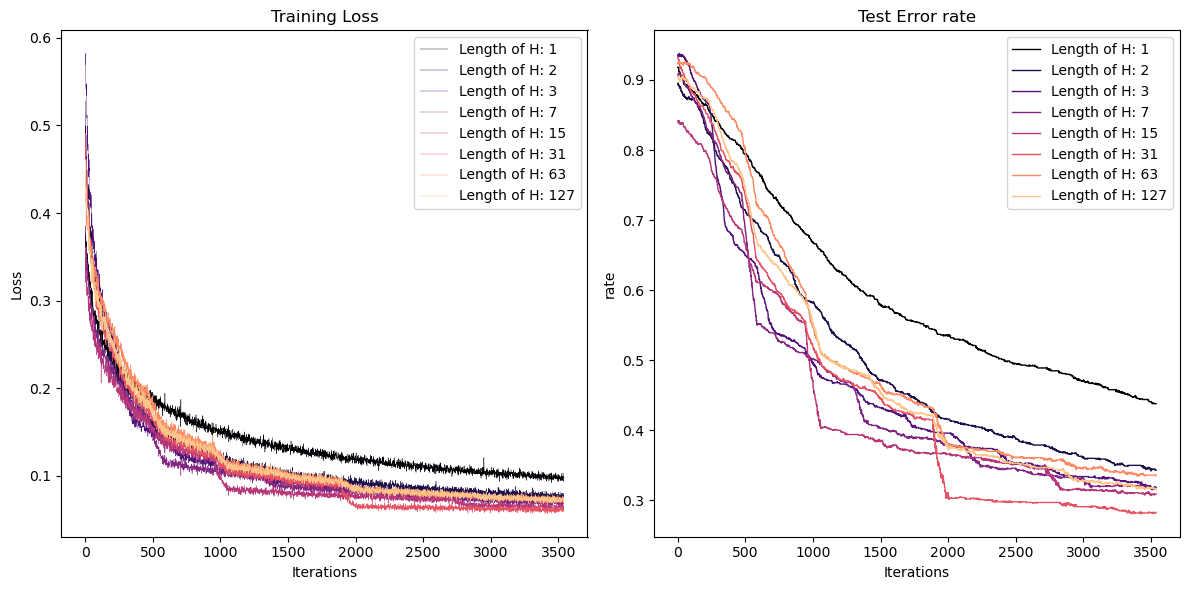

In [58]:

# Load the loss and test error data
losses_H = np.load('losses_H.npy')
test_error_rates_H = np.load('test_error_rates_H.npy')

# Create a color map for plotting
cmap = cm.get_cmap('magma')

# Plot losses_H
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i, losses in enumerate(losses_H):
    plt.plot(losses, label=f"Length of H: {len(H[i])}", color=cmap(i / len(losses_H)), linewidth=0.3)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Plot test_error_rates_H
plt.subplot(1, 2, 2)
for i, test_error_rates in enumerate(test_error_rates_H):
    plt.plot(test_error_rates, label=f"Length of H: {len(H[i])}", color=cmap(i / len(test_error_rates_H)), linewidth=1)
plt.xlabel("Iterations")
plt.ylabel("rate")
plt.title("Test Error rate")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
